<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session_2.5_Assignment/assigment2.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST dataset train and test

In [361]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [362]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms

In [363]:
print ("Pytorch version:", torch.__version__)

Pytorch version: 1.13.0+cu116


Select GPU mode

In [364]:
# Check if GPU available
if torch.cuda.is_available():
  print ("On GPU")
else :
  print ("No GPU available")
     
device = 'cuda' if torch.cuda.is_available() else 'cpu'

No GPU available


# Creating a custom dataset

In [365]:
import random
from torch.utils.data import Dataset

In [366]:
mnist =  torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform = transforms.Compose([
          transforms.ToTensor()
    ])
)

### One value in dataset

In [367]:
train_loader = torch.utils.data.DataLoader(mnist, batch_size = 1, shuffle=True)

label: tensor(6)
Random number generated: tensor(8)
Addition(randnum+image): tensor(14)
Image:


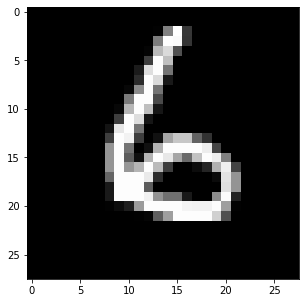

In [368]:
# creating custom dataset
class MyDataset(Dataset):
  def __init__(self):
    batch = next(iter(train_loader))
    self.data = batch[0]
    self.label = batch[1]

  def __getitem__(self, index):
    image = self.data[index]
    label = self.label[index]
    z = torch.tensor(random.randint(0, 9))
    return image, label, z, label+z

  def __len__(self):
    return len(self.data)

myData = MyDataset()

for m in myData:
  print ("label:", m[1])
  print ("Random number generated:", m[2])
  print ("Addition(randnum+image):", m[3])
  print ("Image:")
  grid = torchvision.utils.make_grid(m[0], nrow=10)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

#print ("here", len(myData))

### Custom dataset

In [369]:
class CustomDataset(Dataset):
  def __init__(self, batch_size = 50000):
    train_loader = torch.utils.data.DataLoader(mnist, batch_size = batch_size, shuffle=True)
    batch = next(iter(train_loader))
    self.data = batch[0]
    self.label = batch[1]

  def __getitem__(self, index):
    image = self.data[index]
    label = self.label[index]
    z = torch.tensor(random.randint(0, 9))
    return image, label, z, label+z

  def __len__(self):
    return len(self.data)

'''
for m in data:
  print ("label:", m[1])
  print ("Random number generated:", m[2])
  print ("Addition(randnum+image):", m[3])
  print ("Image:")
  grid = torchvision.utils.make_grid(m[0], nrow=10)
  plt.figure(figsize=(2,2))
  plt.imshow(np.transpose(grid, (1,2,0)))
'''


'\nfor m in data:\n  print ("label:", m[1])\n  print ("Random number generated:", m[2])\n  print ("Addition(randnum+image):", m[3])\n  print ("Image:")\n  grid = torchvision.utils.make_grid(m[0], nrow=10)\n  plt.figure(figsize=(2,2))\n  plt.imshow(np.transpose(grid, (1,2,0)))\n'

# Create a model

In [370]:
import torch.nn.functional as F
import torch.optim as optim

In [371]:
class LeNet(torch.nn.Module):
     
  def __init__(self):   
        super(LeNet, self).__init__()
        # Convolution (In LeNet, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        # Max-pooling
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        # Convolution
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)
        # Fully connected layer
        self.fc1 = torch.nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = torch.nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = torch.nn.Linear(84, 10)        # convert matrix with 84 features to a matrix of 10 features (columns)
        
  def forward(self, out):
        # convolve, then perform ReLU non-linearity
        out = torch.nn.functional.relu(self.conv1(out))  
        # max-pooling with 2x2 grid
        out = self.max_pool_1(out)
        # convolve, then perform ReLU non-linearity
        out = torch.nn.functional.relu(self.conv2(out))
        # max-pooling with 2x2 grid
        out = self.max_pool_2(out)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        out = out.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        out = torch.nn.functional.relu(self.fc1(out))
        # FC-2, then perform ReLU non-linearity
        out = torch.nn.functional.relu(self.fc2(out))
        # FC-3
        out = self.fc3(out)
        
        return out

In [372]:
model = LeNet()
model.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Train the model

In [373]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

In [374]:
data = CustomDataset(len(mnist)) # 256 is the batch size
#print (len(data))
loader = torch.utils.data.DataLoader(data, batch_size=500)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
  total_loss = 0
  total_correct = 0
  for images, labels, rd, rl in loader: # Get Batch
      #print (images.size(), labels.size())
      images = images.to(device)
      labels = labels.to(device)
      preds = model(images) # Pass Batch
      loss = F.cross_entropy(preds, labels) # Calculate Loss

      optimizer.zero_grad()
      loss.backward() # Calculate Gradients
      optimizer.step() # Update Weights

      total_loss += loss.item()
      total_correct += get_num_correct(preds, labels)

  print(
      "epoch:", epoch, 
      #"total_correct:", total_correct/len(train_set)*100, 
      "accuracy(percentage):", total_correct/len(mnist)*100,
      #"loss:", total_loss/len(train_loader)
      "loss:", total_loss,
  )

60000
epoch: 0 accuracy(percentage): 87.65166666666667 loss: 45.02319601178169
epoch: 1 accuracy(percentage): 97.84666666666666 loss: 8.30497346445918
epoch: 2 accuracy(percentage): 98.58333333333333 loss: 5.609492338262498
epoch: 3 accuracy(percentage): 98.86500000000001 loss: 4.5363947679288685
epoch: 4 accuracy(percentage): 98.97833333333334 loss: 3.8929911381565034
epoch: 5 accuracy(percentage): 99.13499999999999 loss: 3.14921368425712
epoch: 6 accuracy(percentage): 99.20333333333333 loss: 2.9940450116991997
epoch: 7 accuracy(percentage): 99.16666666666667 loss: 3.192367531824857
epoch: 8 accuracy(percentage): 99.245 loss: 2.802656739251688
epoch: 9 accuracy(percentage): 99.33999999999999 loss: 2.541642345720902
